In [1]:
import MarsGT 
from MarsGT.conv import *
from MarsGT.egrn import *
from MarsGT.marsgt_model import *
from MarsGT.utils import *
import anndata as ad
from collections import Counter
import copy
import dill
from functools import partial
import json
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pandas as pd
from operator import itemgetter
import random
import scipy.sparse as sp
from scipy.io import mmread
from scipy.sparse import hstack, vstack, coo_matrix
import seaborn as sb
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score
import time
import torch
import torch.cuda as cuda
from torch import nn
from torch.autograd import Variable
import torch.distributions as D
import torch.nn.functional as F
import torch_geometric.data as Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, uniform
from torch_geometric.utils import softmax as Softmax
from torchmetrics.functional import pairwise_cosine_similarity
import warnings
from warnings import filterwarnings
import xlwt
import argparse
from tqdm import tqdm
import scanpy as sc

## Initialize parameters

In [12]:
filterwarnings("ignore")
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

parser = argparse.ArgumentParser(description='Training GNN on gene cell graph')
parser.add_argument('--fi', type=int, default=0) # This parameter is used for the benchmark to specify the starting sequence number of the created files
parser.add_argument('--labsm', type=float, default=0.1) # The rate of LabelSmoothing
parser.add_argument('--wd', type=float, default=0.1) # The 'weight_decay' parameter is used to specify the strength of L2 regularization
parser.add_argument('--lr', type=float, default=0.0005) # learning rate
parser.add_argument('--n_hid', type=int, default=104) # The number of layers should be a multiple of 'n_head' in order to make any modifications
parser.add_argument('--nheads', type=int, default=8) # The 'heads' parameter represents the number of attention heads in the attention mechanism
parser.add_argument('--nlayers', type=int, default=3) # The number of layers in network
parser.add_argument('--cell_size', type=int, default=30) # The number of cells per subgraph (batch)
parser.add_argument('--neighbor', type=int, default=20) # The number of neighboring nodes to be selected for each cell in the subgraph
parser.add_argument('--egrn', type=bool, default=True) # Whether to output the Enhancer-Gene regulatory network
parser.add_argument('--output_file', type=str, default='Z:\mtduan\HGT\Mouse_retina\output') # Please replace the actual path with the path you want. 
args = parser.parse_args([])

output_file = args.output_file
fi=args.fi
labsm = args.labsm
lr = args.lr
wd = args.wd
n_hid = args.n_hid
nheads = args.nheads
nlayers = args.nlayers
cell_size = args.cell_size
neighbor = args.neighbor
egrn = args.egrn

## Load the data

In [3]:
os.chdir('Z:\mtduan\HGT\Mouse_retina/')
RNA_cell_label = pd.read_csv('Cell_type.tsv', sep='\t', header=None)
gene_peak = ad.read_mtx('Gene_Peak.mtx')
gene_cell = ad.read_mtx('Gene_Cell.mtx')
peak_cell = ad.read_mtx('Peak_Cell.mtx')
gene_names = pd.read_csv('Gene_names.tsv', sep='\t', header=None)
cell_names = pd.read_csv('Cell_names.tsv', sep='\t', header=None)
peak_names = pd.read_csv('Peak_names.tsv', sep='\t', header=None)

true_label = np.array(RNA_cell_label[0])
peak_cell.obs_names = peak_names[0]
peak_cell.var_names = cell_names[0]
gene_cell.obs_names = gene_names[0]
gene_cell.var_names = cell_names[0]
gene_peak.obs_names = gene_names[0]
gene_peak.var_names = peak_names[0]

RNA_matrix = gene_cell.X
ATAC_matrix = peak_cell.X
RP_matrix = gene_peak.X
Gene_Peak = gene_peak.X

cell_num = RNA_matrix.shape[1]
gene_num = RNA_matrix.shape[0]
peak_num = ATAC_matrix.shape[0]

## Run the main code

In [4]:
if __name__ == "__main__":
    device = torch.device("cuda" if cuda.is_available() else "cpu")
    print('You will use : ',device)
    # clustering result by scanpy
    initial_pre = initial_clustering(RNA_matrix) 
    # number of every cluster
    cluster_ini_num = len(set(initial_pre)) 
    ini_p1 = [int(i) for i in initial_pre] 
    # partite the data into batches
    indices, Node_Ids, dic = batch_select_whole (RNA_matrix, ATAC_matrix, neighbor = [neighbor], cell_size=cell_size)
    n_batch = len(indices)
    
    # Reduce the dimensionality of features for cell, gene, and peak data.
    node_model = NodeDimensionReduction(RNA_matrix, ATAC_matrix, indices, ini_p1, n_hid=n_hid, n_heads=nheads, 
                                        n_layers=nlayers,labsm=labsm, lr=lr, wd=wd, device=device, num_types=3, num_relations=2, epochs=1)
    gnn,cell_emb,gene_emb,peak_emb,h = node_model.train_model(n_batch=n_batch)

    # Instantiate the MarsGT_model
    MarsGT_model = MarsGT(gnn=gnn, h=h, labsm=labsm, n_hid=n_hid, n_batch=n_batch, device=device,lr=lr,wd=wd, num_epochs=1)
    # Train the model
    MarsGT_gnn = MarsGT_model.train_model(indices=indices,RNA_matrix=RNA_matrix, ATAC_matrix=ATAC_matrix, Gene_Peak=Gene_Peak, ini_p1=ini_p1)
    # The result of MarsGT
    MarsGT_result = MarsGT_pred(RNA_matrix, ATAC_matrix, RP_matrix, egrn=egrn, MarsGT_gnn=MarsGT_gnn, indices=indices, 
                        nodes_id=Node_Ids, cell_size=cell_size, device=device, gene_names=gene_names, peak_names=peak_names)
    
    # Save numpy arrays to files
    np.save(output_file + "/Node_Ids.npy", Node_Ids)
    np.save(output_file + "/pred.npy", MarsGT_result['pred_label'])
    np.save(output_file + "/cell_embedding.npy", MarsGT_result['cell_embedding'])

You will use :  cpu
	When the number of cells is less than or equal to 500, it is recommended to set the resolution value to 0.2.
	When the number of cells is within the range of 500 to 5000, the resolution value should be set to 0.5.
	When the number of cells is greater than 5000, the resolution value should be set to 0.8.
         Falling back to preprocessing with `sc.pp.pca` and default params.
We are currently in the process of partitioning the data into batches. Kindly wait for a moment, please.


100%|██████████| 313/313 [07:50<00:00,  1.50s/it]


The training process for the NodeDimensionReduction model has started. Please wait.


100%|██████████| 1/1 [01:03<00:00, 63.36s/it]


The training for the NodeDimensionReduction model has been completed.
The training process for the MarsGT model has started. Please wait.


100%|██████████| 313/313 [07:23<00:00,  1.42s/it]


The training for the MarsGT model has been completed.


100%|██████████| 313/313 [00:25<00:00, 12.36it/s]


We are currently performing calculations for EGRN. Please bear with us as this process will take approximately around 10 minutes.
class_num: 18
We are currently conducting filtering and categorization operations.


In [5]:
MarsGT_result['egrn'][MarsGT_result['egrn']['class']==1]

,gene,peak,score,class
343624516,Ttf1,chr2:29194127-29196308,129.939521,1
343624515,Ttf1,chr2:29191479-29193244,36.244824,1
248060631,Prph2,chr17:46908034-46935184,26.466061,1
60926177,Cfap77,chr2:29194127-29196308,12.269663,1
295565027,Slc6a6,chr6:91682646-91699915,5.623365,1
...,...,...,...,...
255322618,Rab19,chr6:39241397-39241840,0.0,1
173671165,Lin28b,chr10:45324075-45324593,0.0,1
189286538,Meox1,chr11:101754119-101754519,0.0,1
13746585,Aknad1,chr3:108882874-108883379,0.0,1


## Downstream analysis

### Data reading

In [30]:
ip_file = 'Z:\mtduan\HGT\Mouse_retina\data/'
nodes_id = list(np.load(ip_file+'Node_Ids.npy'))
label = np.array(pd.read_csv(ip_file+'Cell_type.tsv', sep='\t', header=None)[0])
pred_label = list(np.load(ip_file+'pred.npy'))
cell_embedding = np.load(ip_file+'cell_embedding.npy')

### Dotplot

#### Dotplot_Total

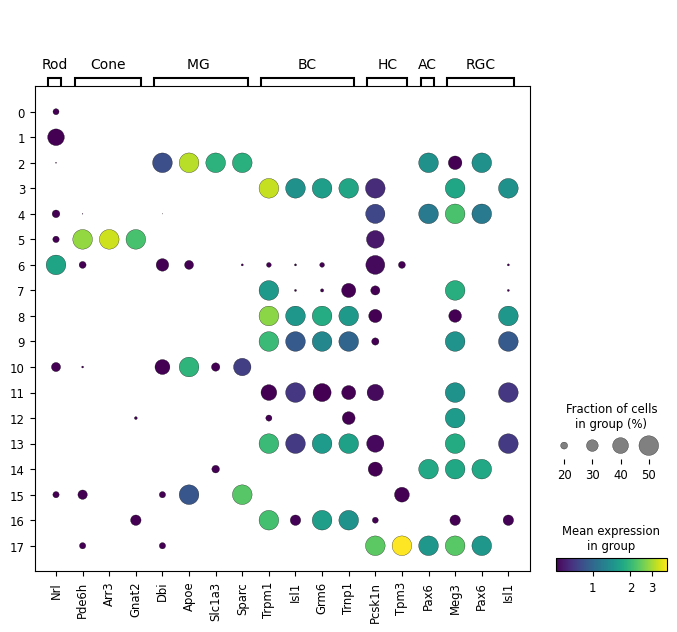

In [50]:
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id]
adata.var_names=gene_names[0]
sc.pp.log1p(adata)
adata.obs['pred_type'] = np.array(pred_label)
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")
marker_genes_dict = {   
    "Rod": ['Nrl'],
    "Cone": ['Pde6h', 'Arr3', 'Gnat2'],
    "MG ":['Dbi','Apoe','Slc1a3','Sparc'],
    "BC":['Trpm1', 'Isl1','Grm6','Trnp1'],
    "HC":['Pcsk1n','Tpm3'],
    "AC":['Pax6'],
    "RGC":['Meg3','Pax6','Isl1']
}
sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',dot_max=0.5,dot_min=0.1,expression_cutoff=0.8,vmin=0.8,vcenter=1.1,color_map='viridis')

#### Dotplot_BC

In [48]:
new_cluster_names = ['Rod','Rod','MG','RBC','RGC','Cone','Rod','BC3','BC6','BC5','MG','BC1','BC4','BC7','AC','MG','BC8/9','HC']

clu_type = np.array(pred_label,dtype='str')
for i in range(18):
    clu_type[clu_type==str(i)]=new_cluster_names[i]

BC_list = [3,7,8,9,11,12,13,16]
BC_index = np.zeros(len(pred_label),dtype='int64')
for BC in BC_list:
    BC_index += np.array(pred_label)==BC

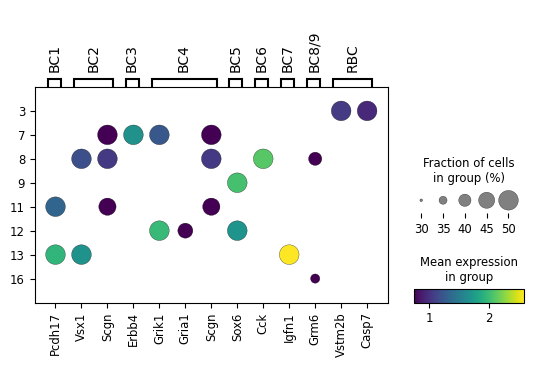

In [49]:
import anndata as ad
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][np.array(BC_index,dtype='bool')]
adata.var_names=gene_names[0]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)

adata.obs['pred_type'] = np.array(pred_label)[np.array(BC_index,dtype='bool')]
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")

marker_genes_dict = {   
    "BC1": ['Pcdh17'],
    "BC2": ['Vsx1','Scgn'],
    "BC3":['Erbb4'],
    "BC4":['Grik1','Gria1','Scgn'],
    "BC5":['Sox6'],
    "BC6":['Cck'],
    "BC7":['Igfn1'],
    "BC8/9":['Grm6'],
    "RBC":['Vstm2b','Casp7']
}

sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',dot_max=0.5,dot_min=0.285,color_map='viridis',expression_cutoff=0.95,vmin=0.8,vcenter=1.5)

### UMAP

#### UMap_Total

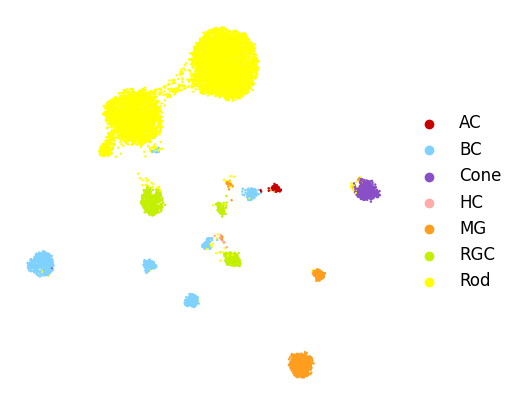

In [16]:
new_cluster_names = ["Rod","Rod", "MG","BC", "RGC", "Cone", "Rod", "RGC", "BC", "BC","MG","BC","RGC","BC","AC","MG","BC","HC"]
clu_type = np.array(pred_label,dtype='str')
for i in range(18):
    clu_type[clu_type==str(i)]=new_cluster_names[i]

adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id]
adata.var_names=gene_names[0]

adata.obs['cell_type'] = np.array(label)
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['pred_type'] = np.array(pred_label)
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")
adata.obs['clu_type'] = np.array(clu_type)
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")
adata.obsm['cell_emb'] = cell_embedding

sc.pp.neighbors(adata, use_rep='cell_emb')
sc.tl.umap(adata)
adata.uns['clu_type_colors'] = [ "#C40003" ,"#7FD2FF", "#894FC6", "#FFACAA", "#FF9D1E", "#C3EF00", '#FFFF00']
color_list = ['AC','BC','Cone','HC','MG','RGC','Rod']
with plt.rc_context({'figure.figsize': (5, 5)}):   
    sc.pl.umap(adata, color= ['clu_type'], add_outline=False,
               legend_fontsize=12, legend_fontoutline=3,frameon=False,title='')

#### UMap_BC

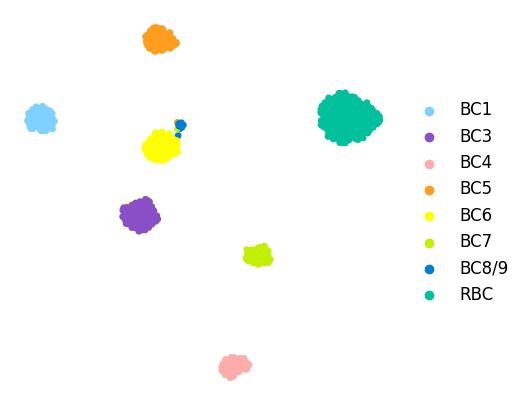

In [17]:
new_cluster_names = ['Rod','Rod','MG','RBC','RGC','Cone','Rod','BC3','BC6','BC5','MG','BC1','BC4','BC7','AC','MG','BC8/9','HC']
clu_type = np.array(pred_label,dtype='str')
for i in range(18):
    clu_type[clu_type==str(i)]=new_cluster_names[i]

BC_list = [3,7,8,9,11,12,13,16]
BC_index = np.zeros(len(pred_label),dtype='int64')
for BC in BC_list:
    BC_index += np.array(pred_label)==BC
BC_index.sum()

import anndata as ad
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][np.array(BC_index,dtype='bool')]
adata.var_names=gene_names[0]

adata.obs['pred_type'] = np.array(pred_label)[np.array(BC_index,dtype='bool')]
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")

adata.obs['clu_type'] = np.array(clu_type)[np.array(BC_index,dtype='bool')]
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")

adata.obsm['cell_emb'] = cell_embedding[np.array(BC_index,dtype='bool')]
sc.pp.neighbors(adata, use_rep='cell_emb')
sc.tl.umap(adata)
adata.uns['clu_type_colors'] = [ "#7FD2FF", "#894FC6", "#FFACAA", "#FF9D1E", '#FFFF00',"#C3EF00", "#007ED3","#00C19B"]

with plt.rc_context({'figure.figsize': (5, 5)}):    
    sc.pl.umap(adata, color= ['clu_type'], add_outline=False,
               legend_fontsize=12, legend_fontoutline=2,frameon=False,title='')

### Heatmap

#### Heatmap_Total

In [18]:
import sys
import io
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    try:
        yield
    finally:
        sys.stdout = old_stdout

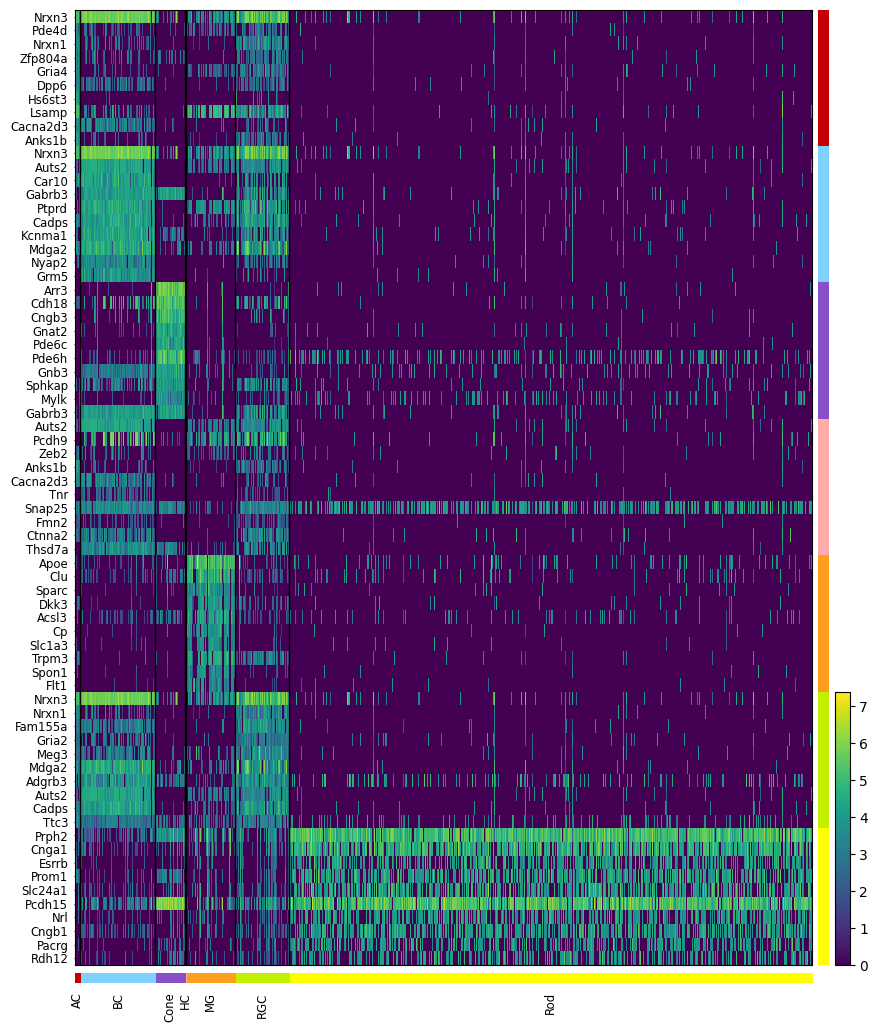

In [19]:
import warnings
warnings.filterwarnings("ignore", message="Default of the method has been changed to 't-test' from 't-test_overestim_var'")

new_cluster_names = ["Rod","Rod", "MG","BC", "RGC", "Cone", "Rod", "RGC", "BC", "BC","MG","BC","RGC","BC","AC","MG","BC","HC"]
clu_type = np.array(pred_label,dtype='str')
for i in range(18):
    clu_type[clu_type==str(i)]=new_cluster_names[i]

import anndata as ad

adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id]
adata.var_names=gene_names[0]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.obs['cell_type'] = np.array(label)
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['pred_type'] = np.array(pred_label)
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")
adata.obs['clu_type'] = np.array(clu_type)
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")

adata.uns['clu_type_colors'] = [ "#C40003" ,"#7FD2FF", "#894FC6", "#FFACAA", "#FF9D1E", "#C3EF00", '#FFFF00']

sc.tl.rank_genes_groups(adata, 'clu_type', method='t-test')
##纵排
with suppress_stdout():
    ax_list = sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, dendrogram=False, show=False, swap_axes=True, show_gene_labels=True)
    ax_list['groupby_ax'].set_xlabel("")

In [20]:
import pandas as pd

rank_genes_groups = adata.uns['rank_genes_groups']

# Store the results in a list
results = []

# Get the top 10 variable genes, adjusted p-values, and log fold changes for each cluster
for group in rank_genes_groups['names'].dtype.names:
    top_genes = rank_genes_groups['names'][group][:10]
    pvals_adj = rank_genes_groups['pvals_adj'][group][:10]
    logfoldchanges = rank_genes_groups['logfoldchanges'][group][:10]

    for gene, pval_adj, logfoldchange in zip(top_genes, pvals_adj, logfoldchanges):
        results.append({
            'Cluster': group,
            'Gene': gene,
            'Adjusted p-value': pval_adj,
            'Log fold change': logfoldchange
        })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Print the DataFrame
results_df.to_csv(output_file + '/Top_Deg.csv')

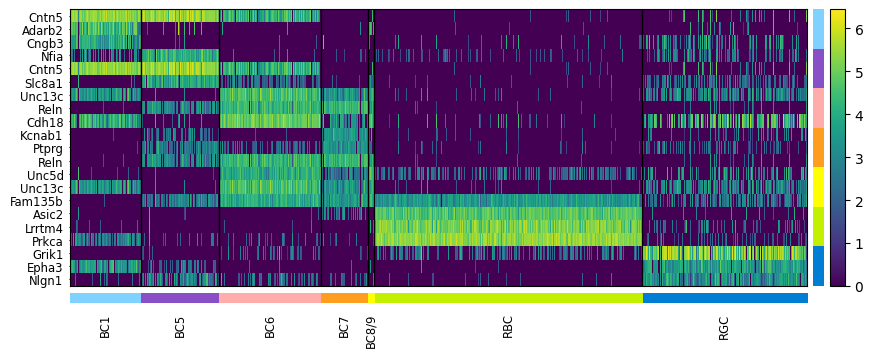

In [21]:
new_cluster_names = ["Rod","Rod", "MG","RBC", "RGC", "Cone", "Rod", "RGC", "BC6", "BC5","MG","BC1","RGC","BC7","AC","MG","BC8/9","HC"]
clu_type = np.array(pred_label,dtype='str')
for i in range(18):
    clu_type[clu_type==str(i)]=new_cluster_names[i]

BC_list = [3,7,8,9,11,12,13,16]
BC_index = np.zeros(len(pred_label),dtype='int64')
for BC in BC_list:
    BC_index += np.array(pred_label)==BC
BC_index.sum()

import anndata as ad
#adata =  ad.AnnData(eGRN, dtype='int32')
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][np.array(BC_index,dtype='bool')]
adata.var_names=gene_names[0]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.obs['clu_type'] = np.array(clu_type)[np.array(BC_index,dtype='bool')]
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")
adata.uns['clu_type_colors'] = [ "#7FD2FF", "#894FC6", "#FFACAA", "#FF9D1E", '#FFFF00',"#C3EF00", "#007ED3","#00C19B"]

sc.tl.rank_genes_groups(adata, 'clu_type', method='t-test')

##纵排
with suppress_stdout():
    ax_list = sc.pl.rank_genes_groups_heatmap(adata,n_genes=3,dendrogram=False,show=False,swap_axes=True)
    ax_list['groupby_ax'].set_xlabel("") # 设置x轴的标签文本

## EGRN

#### EGRN_Total

In [ ]:
new_cluster_names = ["Rod","Rod", "MG","BC", "RGC", "Cone", "Rod", "RGC", "BC", "BC","MG","BC","RGC","BC","AC","MG","BC","HC"]
color_list = ['AC','BC','Cone','HC','MG','RGC','Rod']
clu_type = np.array(pred_label,dtype='str')
for i in range(18):
    clu_type[clu_type==str(i)]=new_cluster_names[i]
clu_type[clu_type==str('AC')]=0
clu_type[clu_type==str('BC')]=1
clu_type[clu_type==str('Cone')]=2
clu_type[clu_type==str('HC')]=3
clu_type[clu_type==str('MG')]=4
clu_type[clu_type==str('RGC')]=5
clu_type[clu_type==str('Rod')]=6

total_egrn_df = egrn_calculate(clu_type, nodes_id, RNA_matrix, ATAC_matrix, RP_matrix, gene_names, peak_names)

We are currently performing calculations for EGRN. Please bear with us as this process will take approximately around 10 minutes.


#### EGRN_BC

In [39]:
def gene_Peak_Score(pred_label,RNA_matrix,ATAC_matrix,gene_names,peak_names,choice_cluser):  
    y = ad.AnnData(RNA_matrix.transpose(), dtype='int32')
    y.var_names=gene_names[0]
    y.obs['pred'] = np.array(pred_label,dtype='int64')
    y.obs['pred'] = y.obs['pred'].astype("category")
    ## 把预测结果存储为稀疏矩阵，行代表细胞，列代表聚类标签 对应位置为1表示该细胞属于该类
    cell_emb_binary = sp.coo_matrix((np.ones(len(y.obs['pred'])),(np.array(range(len(y.obs['pred']))),list(y.obs['pred']))))
    cell_emb_binary.todense()

    adata_atac_all = ATAC_matrix
    adata_rna_all = RNA_matrix

    ATAC_matrix_ct = adata_atac_all*(cell_emb_binary)
    RNA_matrix_ct = adata_rna_all*(cell_emb_binary)
    
    RNA_matrix_ct = RNA_matrix_ct/np.sum(cell_emb_binary,axis=0)
    ATAC_matrix_ct = ATAC_matrix_ct/np.sum(cell_emb_binary,axis=0)

    rna_matrix = RNA_matrix_ct
    m = range(rna_matrix.shape[0])
    gene_peak = RP_matrix
    gp = gene_peak.reshape(gene_peak.shape[1]*rna_matrix.shape[0],1).todense()
    gene_emb_enh = ATAC_matrix_ct[list(range (ATAC_matrix_ct.shape[0]))*rna_matrix.shape[0]]
    peak_emb_enh = RNA_matrix_ct[[v for v in m for i in range(ATAC_matrix_ct.shape[0])]]
    egrn = np.multiply(gene_emb_enh, peak_emb_enh)
    egrn = np.multiply(egrn,gp)
    
    gn = np.array(gene_names[0])[[v for v in m for i in range(ATAC_matrix.shape[0])]]
    pn = np.array(peak_names[0])[list(range (ATAC_matrix.shape[0]))*RNA_matrix.shape[0]]
    data = np.array(np.squeeze(egrn[:,choice_cluser]))[0]
    
    gene_peak_score_Dict = {'gene': gn, 'peak': pn, 'score':data}
    gene_peak_score_df = pd.DataFrame(data = gene_peak_score_Dict)
    gene_peak_score = gene_peak_score_df[gene_peak_score_df['score'] > 1]
    gene_peak_score = gene_peak_score.drop_duplicates(['gene','peak'])
    gene_peak_score = gene_peak_score.sort_values(by="score",ascending=False)
    
#     print(gene_peak_score.head())
    
    return gene_peak_score_df,gene_peak_score

In [8]:
new_cluster_names = ["Rod","Rod", "MG","RBC", "RGC", "Cone", "Rod", "RGC", "BC6", "BC5","MG","BC1","RGC","BC7","AC","MG","BC8/9","HC"]

clu_type = np.array(pred_label,dtype='str')
for i in range(18):
    clu_type[clu_type==str(i)]=new_cluster_names[i]

BC_list = [3,8,9,11,13,16]
BC_index = np.zeros(len(pred_label),dtype='int64')
for BC in BC_list:
    BC_index += np.array(pred_label)==BC
BC_index.sum()

clu_type[clu_type==str('BC1')]=0
clu_type[clu_type==str('BC5')]=1
clu_type[clu_type==str('BC6')]=2
clu_type[clu_type==str('BC7')]=3
clu_type[clu_type==str('BC8/9')]=4
clu_type[clu_type==str('RBC')]=5

BC_RNA_matrix = RNA_matrix[:,np.array(nodes_id)[np.array(BC_index,dtype='bool')]]
BC_ATAC_matrix = ATAC_matrix[:,np.array(nodes_id)[np.array(BC_index,dtype='bool')]]
BC_clu_type = clu_type[np.array(BC_index,dtype='bool')]

In [41]:
BC_name = ['BC1','BC5','BC6','BC7','BC8/9','RBC']
BC_socre_df = pd.DataFrame(columns=['gene', 'peak', 'score', 'class'])
for i in range(6):
    BC_gene_peak_score_df,BC_gene_peak_score = gene_Peak_Score(BC_clu_type,BC_RNA_matrix,BC_ATAC_matrix,gene_names,peak_names,choice_cluser=i)
    BC_gene_peak_score_df = BC_gene_peak_score_df[BC_gene_peak_score_df['score'] > 0]
    BC_gene_peak_score_df['class'] = BC_name[i]
    BC_socre_df = BC_socre_df.append(BC_gene_peak_score_df.sort_values(by="score",ascending=False))
BC_socre_df.sort_values(by="score",ascending=False)

,gene,peak,score,class
343624516,Ttf1,chr2:29194127-29196308,381.803558,BC8/9
343624516,Ttf1,chr2:29194127-29196308,204.879398,BC1
343624516,Ttf1,chr2:29194127-29196308,192.48141,BC5
343624516,Ttf1,chr2:29194127-29196308,166.249687,BC6
343624516,Ttf1,chr2:29194127-29196308,113.900963,BC7
...,...,...,...,...
145819897,Hrc,chr7:45188645-45189821,0.0,RBC
136550857,Grik3,chr4:125636554-125637050,0.0,RBC
111038506,Fbxo17,chr7:28570211-28570828,0.0,RBC
220517986,P3h2,chr16:25958246-25958650,0.0,RBC


### BC_GO

In [31]:
Reference_df = pd.read_csv('Z:\mtduan\HGT\Mouse_retina\BC_GO\Reference.csv',encoding='utf-8')
GO_df3 = pd.read_csv('Z:\mtduan\HGT\Mouse_retina\BC_GO\BC_GO.csv',encoding='utf-8')

GO_DF = pd.DataFrame(columns=['Class','ID','Term','Genes'])
GO_ID = Reference_df.loc[:,'ID'].unique()
GO_Term = Reference_df.loc[:,'Term'].unique()

G = []
for name in GO_ID:
    if len(GO_df3[GO_df3.loc[:,'ID']==name])>0:
        G = G + [name]  
GO_ID = G
        
for index,ID in enumerate(GO_ID):
    Match_df = GO_df3[GO_df3.loc[:,'ID']==ID]
    Match_num = len(Match_df)
    gene_list = []
    for i in range(Match_num):
        gene_list += Match_df.iloc[i,4].replace(" ","").split(',')
    gene_list = list(set(gene_list))
    GO_DF.loc[index]={'Class':random.choice(list(Match_df['Class'])),'ID':ID,'Term':Match_df.iloc[i,3],'Genes':gene_list}
    
GO_DF

,Class,ID,Term,Genes
0,BC9,GO:0042734,presynaptic membrane,"[Cadps2, Grin2b, Grm7, Kctd16, Pcdh17, Ntng1, ..."
1,BC12,GO:0050808,synapse organization,"[Gabrb3, Slitrk5, Neurod2, Myo5a, Gabra1, Nfia..."
2,BC7,GO:0097485,neuron projection guidance,"[Unc5d, Lrp1, Tgfb2, Prtg, Nova2, Ablim1, Cntn..."
3,BC7,GO:0060291,long-term synaptic potentiation,"[Scgn, Rims1, Grin2b, Adcy8, Nlgn1, App]"
4,BC16,GO:0015079,potassium ion transmembrane transporter activity,"[Kcnip4, Kcng4, Kcnab1, Slc24a2, Kcnma1, Kcnh5..."
...,...,...,...,...
92,BC16,GO:1990778,protein localization to cell periphery,"[Ank3, Efr3b, Rock2, Sorbs1, Lin7a, Snap25, Ki..."
93,BC11,GO:1904062,regulation of cation transmembrane transport,"[Cacna2d1, Tgfb2, Adrb1, Shisa9, Stim2, Pde4d,..."
94,BC7,GO:0097120,receptor localization to synapse,"[Cep112, Snap25, Grip1, Anks1b, Nrxn1, Nlgn1, ..."
95,BC16,GO:0008277,regulation of G protein-coupled receptor signa...,"[Grm5, Pde10a, Rock2, Kctd8, Adrb1, Plcb1, Kct..."


In [32]:
RBC_list = list(GO_DF[GO_DF['Class']=='BC3']['Term'])
BC3_list = list(GO_DF[GO_DF['Class']=='BC7']['Term'])
BC6_list = list(GO_DF[GO_DF['Class']=='BC8']['Term'])
BC5_list = list(GO_DF[GO_DF['Class']=='BC9']['Term'])
BC1_list = list(GO_DF[GO_DF['Class']=='BC11']['Term'])
BC4_list = list(GO_DF[GO_DF['Class']=='BC12']['Term'])
BC7_list = list(GO_DF[GO_DF['Class']=='BC13']['Term'])
BC8_9_list = list(GO_DF[GO_DF['Class']=='BC16']['Term'])
None_list = list(GO_DF[GO_DF['Class']=='None']['Term'])

marker_dicts = {'BC1':BC1_list,'BC3':BC3_list,'BC4':BC4_list,'BC5':BC5_list,
                'BC6':BC6_list,'BC7':BC7_list,'BC8_9':BC8_9_list,'RBC':RBC_list}

new_cluster_names = ['Rod','Rod','MG','RBC','RGC','Cone','Rod','BC3','BC6','BC5','MG','BC1','BC4','BC7','AC','MG','BC8/9','HC']

clu_type = np.array(pred_label,dtype='str')
for i in range(18):
    clu_type[clu_type==str(i)]=new_cluster_names[i]

BC_list = [3,7,8,9,11,12,13,16]
BC_index = np.zeros(len(pred_label),dtype='int64')
for BC in BC_list:
    BC_index += np.array(pred_label)==BC
BC_index.sum()

import anndata as ad
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][np.array(BC_index,dtype='bool')]
adata.var_names=gene_names[0]

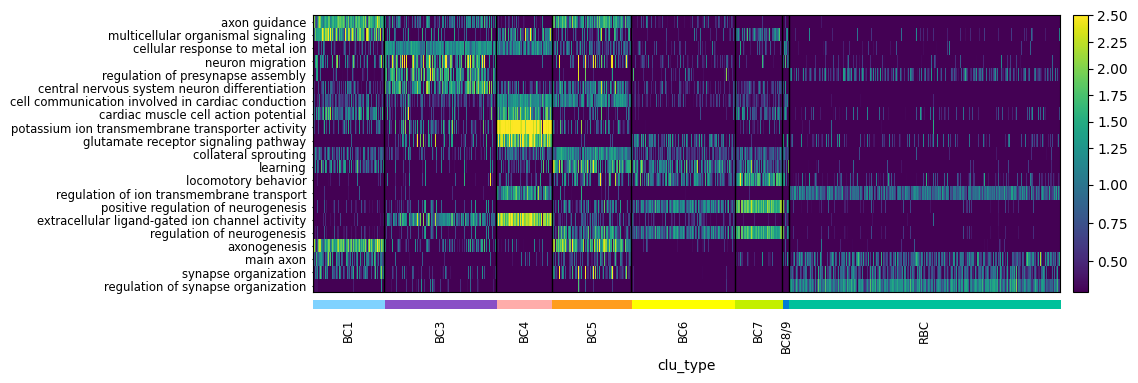

In [33]:
expression = np.zeros((1231,len(GO_DF)))
for index in range(len(GO_DF)):
    expression[:,index] = np.squeeze(np.array(adata[:,np.array(GO_DF.iloc[index,3])].X.todense()).mean(axis=1))
    
adata =  ad.AnnData(expression,dtype='float32')
adata.var_names=np.array(GO_DF.loc[:,'Term'])

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)
adata.obs['clu_type'] = np.array(clu_type)[np.array(BC_index,dtype='bool')]
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")
adata.uns['clu_type_colors'] = [ "#7FD2FF", "#894FC6", "#FFACAA", "#FF9D1E", '#FFFF00',"#C3EF00", "#007ED3","#00C19B"]

marker_dicts=['axon guidance','multicellular organismal signaling','cellular response to metal ion','neuron migration',
              'regulation of presynapse assembly','central nervous system neuron differentiation','cell communication involved in cardiac conduction','cardiac muscle cell action potential',
            'potassium ion transmembrane transporter activity','glutamate receptor signaling pathway','collateral sprouting','learning','locomotory behavior',
            'regulation of ion transmembrane transport','positive regulation of neurogenesis','extracellular ligand-gated ion channel activity',
            'regulation of neurogenesis','axonogenesis','main axon','synapse organization','regulation of synapse organization']
sc.pl.heatmap(adata,marker_dicts,groupby='clu_type',swap_axes=True,vcenter=1.2,vmin=0.3,vmax=2.5,show_gene_labels=True)

## GSEA

#### To study category 2, we will filter out categories 10 and 15

Text(0.5, 0, '')

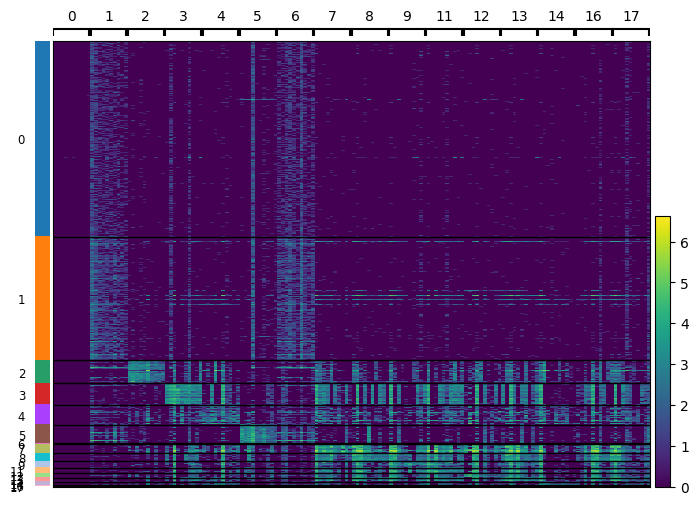

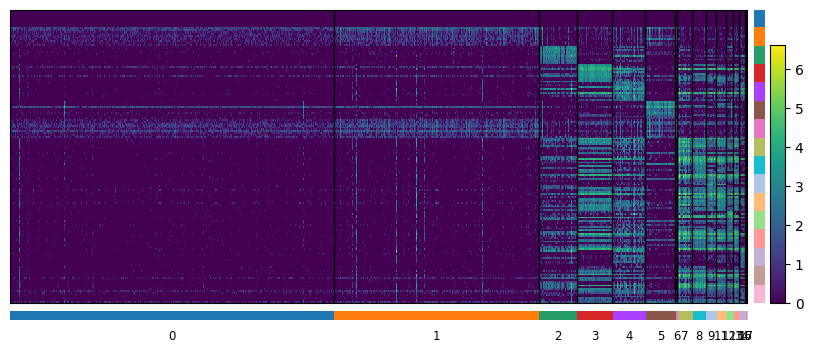

In [46]:
filter_label = np.array(pred_label)
fileter_index1 = filter_label==15
fileter_index2 = filter_label==10
fileter_index = fileter_index1+fileter_index2
fileter_index
filter_label = filter_label[~fileter_index]
filter_label.shape

adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][~fileter_index]

adata.var_names=gene_names[0]
sc.pp.log1p(adata)

adata.obs['clu_type'] = np.array(pred_label)[~fileter_index]
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")
adata.obsm['cell_emb'] = cell_embedding[~fileter_index]

sc.pp.neighbors(adata, use_rep='cell_emb')
sc.tl.umap(adata)


sc.tl.rank_genes_groups(adata, 'clu_type')

ax_list = sc.pl.rank_genes_groups_heatmap(adata,n_genes=10,dendrogram=False,show=False)
ax_list['groupby_ax'].set_ylabel("") 

ax_list = sc.pl.rank_genes_groups_heatmap(adata,n_genes=10,dendrogram=False,show=False,swap_axes=True)
ax_list['groupby_ax'].set_xlabel("") 

#### To study category 10, we will filter out categories 2 and 15

Text(0.5, 0, '')

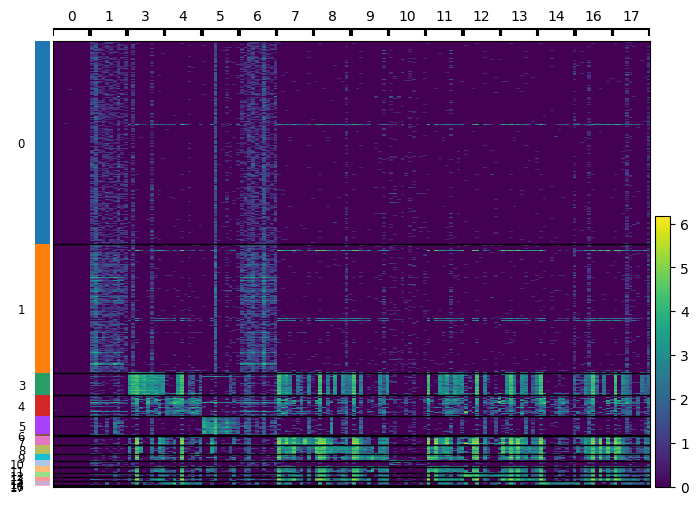

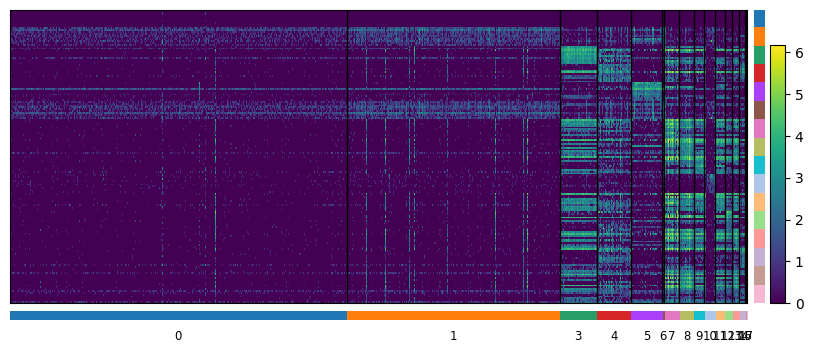

In [47]:
filter_label = np.array(pred_label)
fileter_index1 = filter_label==15
fileter_index2 = filter_label==2
fileter_index = fileter_index1+fileter_index2
fileter_index
filter_label = filter_label[~fileter_index]
filter_label.shape

adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][~fileter_index]

adata.var_names=gene_names[0]
# sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.scale(adata,max_value=10)

adata.obs['clu_type'] = np.array(pred_label)[~fileter_index]
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")
adata.obsm['cell_emb'] = cell_embedding[~fileter_index]
#sc.tl.pca(adata, n_comps=50)
#m_PCA = adata.obsm['X_pca']
sc.pp.neighbors(adata, use_rep='cell_emb')
sc.tl.umap(adata)
sc.tl.rank_genes_groups(adata, 'clu_type')

ax_list = sc.pl.rank_genes_groups_heatmap(adata,n_genes=10,dendrogram=False,show=False)
ax_list['groupby_ax'].set_ylabel("") 

ax_list = sc.pl.rank_genes_groups_heatmap(adata,n_genes=10,dendrogram=False,show=False,swap_axes=True)
ax_list['groupby_ax'].set_xlabel("")